# Extract data from the ESIDA DB

The ESIDA database holds multiple data, for one the shapes of the different geographical areas, like regions and districts, to which the collected parameters of interest (like weather or socio-economical) are mapped.

In this notebook examples for accessing those data are provided.


In [2]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

First, we need to configure the URL of the database and the potential password to access the API. In case of the HAW hosted instance, run the second cell below.

In [3]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [4]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get shapes from database

The database can hold different geographical areas which are of interest to the project. In our case those are the regions and districts of Tanzania. With the following API calls those shapes can be extracted off the database. The IDs of each shape can subsequently be used to query the parameter data stored for the shape.

In [5]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])
regions = dict(zip(regions_gdf.id, regions_gdf.name))

# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'district',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
districts_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    districts_gdf['geometry'] = geopandas.GeoSeries.from_wkt(districts_gdf['wkt'])
    districts_gdf = districts_gdf.drop(columns=['wkt'])
districts = dict(zip(districts_gdf.id, districts_gdf.name))

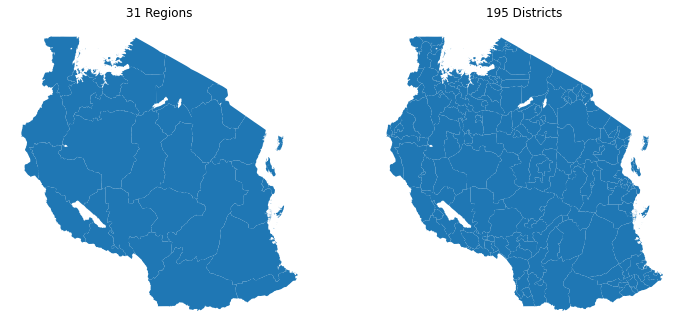

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))

regions_gdf.plot(ax=axes[0])
axes[0].axis('off')
axes[0].set_title(f'{len(regions_gdf)} Regions')

districts_gdf.plot(ax=axes[1])
axes[1].axis('off')
axes[1].set_title(f'{len(districts_gdf)} Districts')

plt.axis('off')
plt.show()

# Available parameters

The available parameters of the database are identified by their unique `parameter_id`. A list of all parameters can be obtained with the following API call.

Also all parameters are documentated in more detail on [the website](https://esida.informatik.haw-hamburg.de/parameter).

In [29]:
q = {}
d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

# DataFrame
datalayers_df = pd.DataFrame(d['data'])

In [30]:
datalayers_df[datalayers_df['loaded'] == True].head()

loaded      parameter_id  raw_data_size spatial_coverage  temporal_actual  \
0    True    chirps_tprecit    15189291028             None         247696.0   
1    True       chirts_maxt      528797948             None         577882.0   
2    True       chirts_mint      528822524             None         577882.0   
4    True  copernicus_built     4596882334             None           1130.0   
5    True   copernicus_crop     4596882334             None           1130.0   

   temporal_coverage  temporal_expected temporal_first temporal_last timelines  
0           0.272840               4017     2018-01-01    2022-04-29      date  
1           0.636545               4017     2010-01-01    2016-12-31      date  
2           0.636545               4017     2010-01-01    2016-12-31      date  
4           0.454545                 11           2015          2019      year  
5           0.454545                 11           2015          2019      year

# Load data for single shape

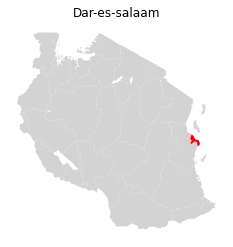

In [31]:
# plot shape we want to look at
# identify the region by name
shape_gdf = regions_gdf[regions_gdf['name'] == 'Dar-es-salaam'].reset_index(drop=True)

shape_id = shape_gdf.at[0, 'id']

ax = regions_gdf.plot(color='lightgray')
shape_gdf.plot(color='red', ax=ax)
plt.title(shape_gdf.at[0, 'name'])
plt.axis('off')
plt.show()

In [32]:
# Download all data for given parameter
q = {
    'filter_parameters': ','.join(['worldpop_popc']), # list of parameters, 
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/shape/{shape_id}?{urlencode(q)}", auth=auth).json()
shape_df = pd.DataFrame(d['data'])

In [33]:
shape_df

worldpop_popc  year
0       4049635.8  2010
1       4294334.0  2011
2       4554449.0  2012
3       4829976.0  2013
4       5121146.0  2014
5       5428955.0  2015
6       5753794.0  2016
7       6097105.5  2017
8       6459003.0  2018
9       6840113.0  2019
10      7239773.0  2020

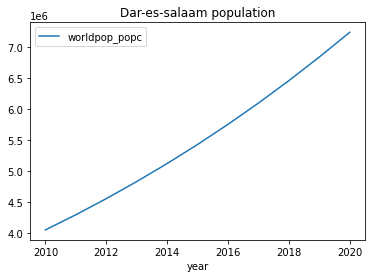

In [34]:
shape_df.plot(x='year', y=['worldpop_popc']) # value column always has the same name as the parmeter
plt.title(f"{shape_gdf.at[0, 'name']} population")
plt.show()

# Load all data of the parameter, for all available shapes

For a single parameter all stored values for each geographical area can be queried.

In [40]:
parameter_id = 'worldpop_popc' # id of the desiered parameter, see list/dataframe above.

q = {
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
param_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [42]:
param_df.head()

shape_id  worldpop_popc  year
0         1      2083944.2  2010
1         2      1661590.6  2010
2         3      1641784.1  2010
3         4      2016205.5  2010
4         5      2205872.2  2010

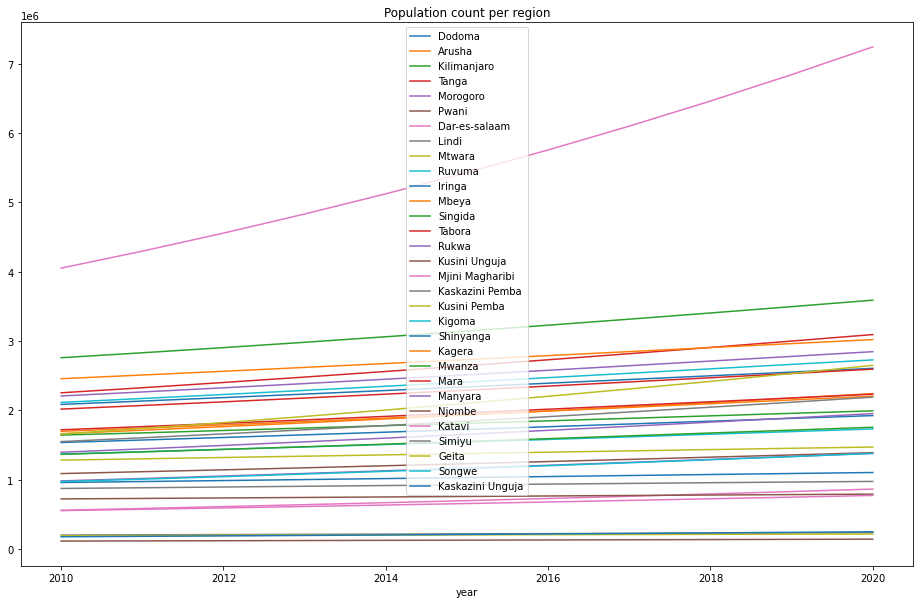

In [41]:
fig, ax = plt.subplots(figsize=(16, 10))

# use regions from above to filter results to only show regions
for sid in regions.keys():
    dfx = param_df[param_df['shape_id'] == sid]
    dfx.plot(x='year', y='worldpop_popc', ax=ax, label=regions[sid])
    
plt.title('Population count per region')
plt.show()

In [38]:
# - filter only regions
# - sort by year to get youngest values
# - get the first x entries -> amount of regions
# => new DF contains the latest value for each region only
latest_df = param_df[param_df['shape_id'].isin(regions.keys())].sort_values(by='year', ascending=False).head(len(regions.keys()))

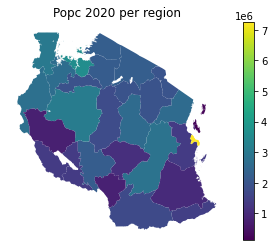

In [39]:
regions_gdf['shape_id'] = regions_gdf['id'] # copy column to merge on
regions_gdf.merge(latest_df, on='shape_id').plot(column='worldpop_popc', legend=True)
plt.title('Popc 2020 per region')
plt.axis('off')
plt.show()

# Load precipitation and Dengue cases for all shapes 

In this example we query the precipitation data for each region, as well as the literature based dengue case reports and plot them together.

In [43]:
parameter_id = 'chirps_tprecit'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
chirps_tprecit_df = pd.DataFrame(d['data'])
chirps_tprecit_df['date'] = pd.to_datetime(chirps_tprecit_df['date'])

In [44]:
parameter_id = 'lit_dengue_out_loc'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
lit_dengue_out_loc_df = pd.DataFrame(d['data'])
lit_dengue_out_loc_df['date'] = pd.to_datetime(lit_dengue_out_loc_df['date'])

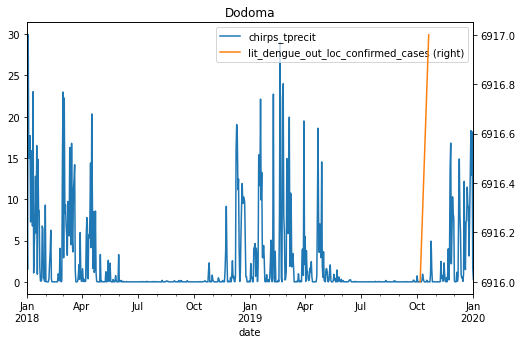

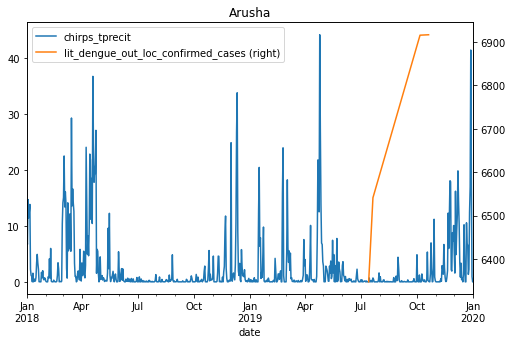

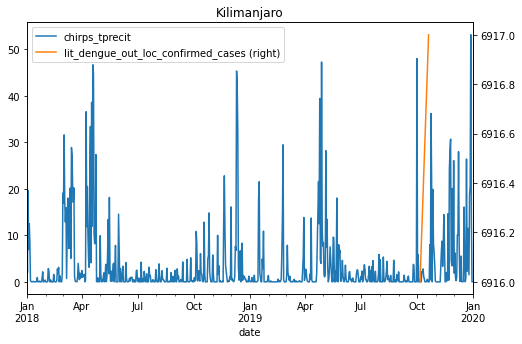

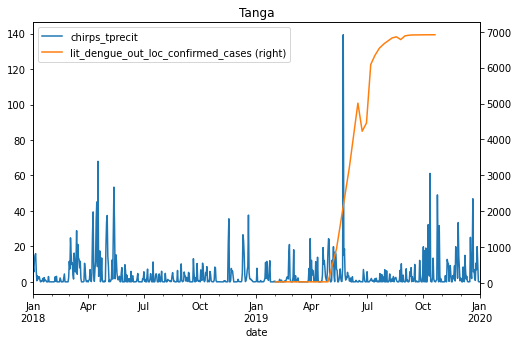

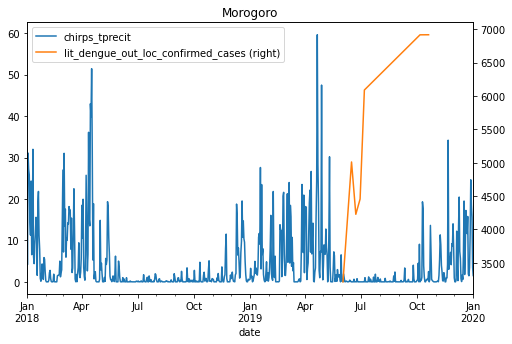

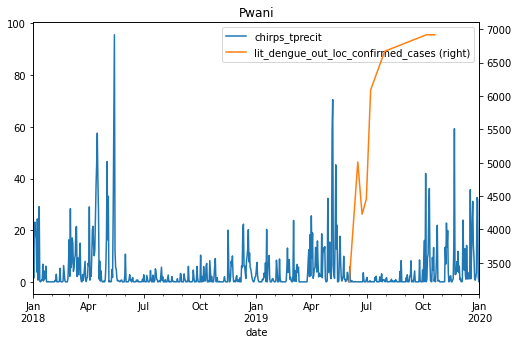

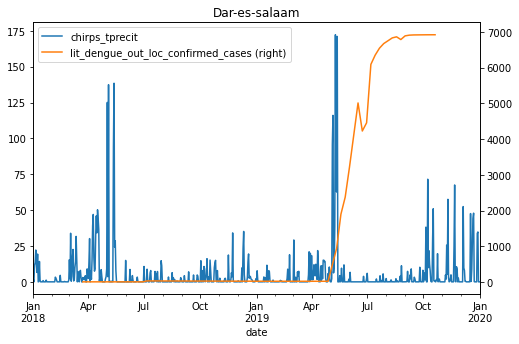

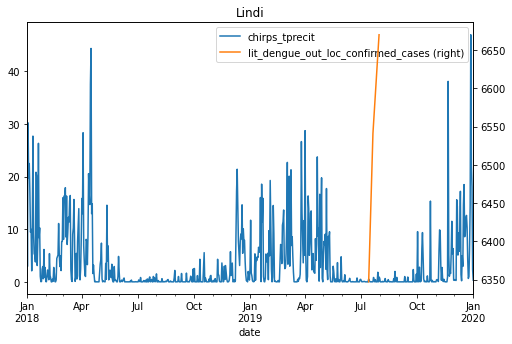

No cases for Mtwara.


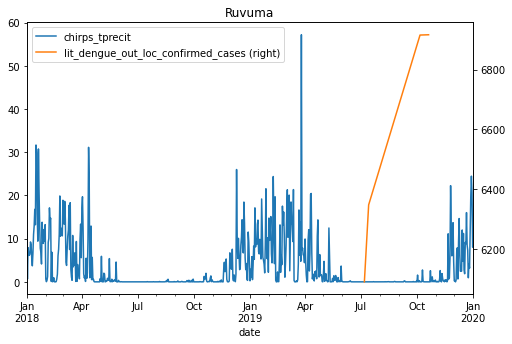

No cases for Iringa.
No cases for Mbeya.


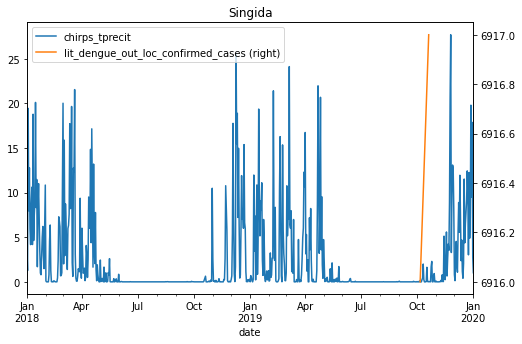

No cases for Tabora.
No cases for Rukwa.
No cases for Kusini Unguja.
No cases for Mjini Magharibi.
No cases for Kaskazini Pemba.
No cases for Kusini Pemba.
No cases for Kigoma.
No cases for Shinyanga.


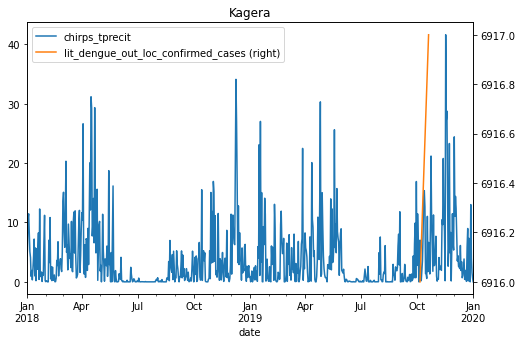

No cases for Mwanza.
No cases for Mara.
No cases for Manyara.
No cases for Njombe.
No cases for Katavi.
No cases for Simiyu.
No cases for Geita.
No cases for Songwe.
No cases for Kaskazini Unguja.


In [45]:
for sid in shape_ids:
    # only build charts for known id's from above
    if sid not in regions.keys():
        continue
        
    # tprecit 
    dfx_tprecit = chirps_tprecit_df[chirps_tprecit_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_tprecit) == 0:
        print(f"No prec. for {regions[sid]}.")
        continue
        
    # cases 
    dfx_cases = lit_dengue_out_loc_df[lit_dengue_out_loc_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_cases) == 0:
        print(f"No cases for {regions[sid]}.")
        continue
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    dfx_tprecit.plot(x='date', y='chirps_tprecit', ax=ax)
    dfx_cases.plot(x='date', y='lit_dengue_out_loc_confirmed_cases', ax=ax, secondary_y=True)

    
    plt.title(regions[sid])
    plt.show()